# PROJET 9 : Réalisez une application mobile de recommandation de contenu

## importation des librairies

In [1]:
pip install --upgrade surprise

     |████████████████████████████████| 11.8 MB 4.0 MB/s eta 0:00:01
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp38-cp38-linux_x86_64.whl size=1834445 sha256=13ec88d8ca270296876646246968098725bc02ca23f13aa1d14bd1925eb32d5a
  Stored in directory: /home/azureuser/.cache/pip/wheels/20/91/57/2965d4cff1b8ac7ed1b6fa25741882af3974b54a31759e10b6
Successfully built scikit-surprise
Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install missingno

Note: you may need to restart the kernel to use updated packages.


In [3]:
import os

import random

import pandas as pd
import numpy as np
from collections import defaultdict

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import missingno

import sklearn
import sklearn.model_selection

from surprise import NormalPredictor
from surprise import Dataset
from surprise import Reader
from surprise.model_selection import cross_validate, train_test_split, GridSearchCV
from surprise import KNNWithMeans, SVD
from surprise import accuracy

import pickle

import glob

#Settings
pd.set_option('display.max_columns', None)
sns.set(color_codes=True)

#To be avoided in your notebook.
import warnings
warnings.filterwarnings("ignore")

## Analyse exploratoire des données

### Contenu de l’ensemble de données
>- **articles_metadata.csv** : fichier CSV contenant des métadonnées sur tous les articles publiés (364047)

>- **articles_embeddings.pickle** : Pickle (Python 3) d’une matrice NumPy contenant les Articles Content Embeddings (vecteurs à 250 dimensions), formés au texte et aux métadonnées des articles par le module ACR de CHAMELEON (voir l’article pour plus de détails) pour 364047 articles publiés.

>- **clics** : Dossier contenant des fichiers CSV (un par heure), contenant les interactions des sessions utilisateur dans le portail de nouvelles.

>- **clicks_sample.csv** : fichier CSV contenant les interactions des sessions utilisateur dans le portail de nouvelles.


In [4]:
[print(x) for x in os.listdir('./input')];

.amlignore
.amlignore.amltmp
articles_embeddings.pickle
articles_metadata.csv
clicks
clicks_sample.csv


## articles_metadata.csv

### Contenu

In [5]:
PATH_ARTICLES_DATA = "./input/articles_metadata.csv"
articles_df = pd.read_csv(PATH_ARTICLES_DATA)

In [6]:
articles_df.head(5)

,article_id,category_id,created_at_ts,publisher_id,words_count
0,0,0,1513144419000,0,168
1,1,1,1405341936000,0,189
2,2,1,1408667706000,0,250
3,3,1,1408468313000,0,230
4,4,1,1407071171000,0,162


articles_metadata.csv contient 5 colonnes :

>- **article_id** : ID de l’article

>- **category_id** : ID de catégorie de l’article

>- **created_at_ts** : Date de création (horodatage)

>- **publisher_id** : ID de l’éditeur

>- **words_count** : Total des mots contenus dans l’article


## Valeurs manquantes

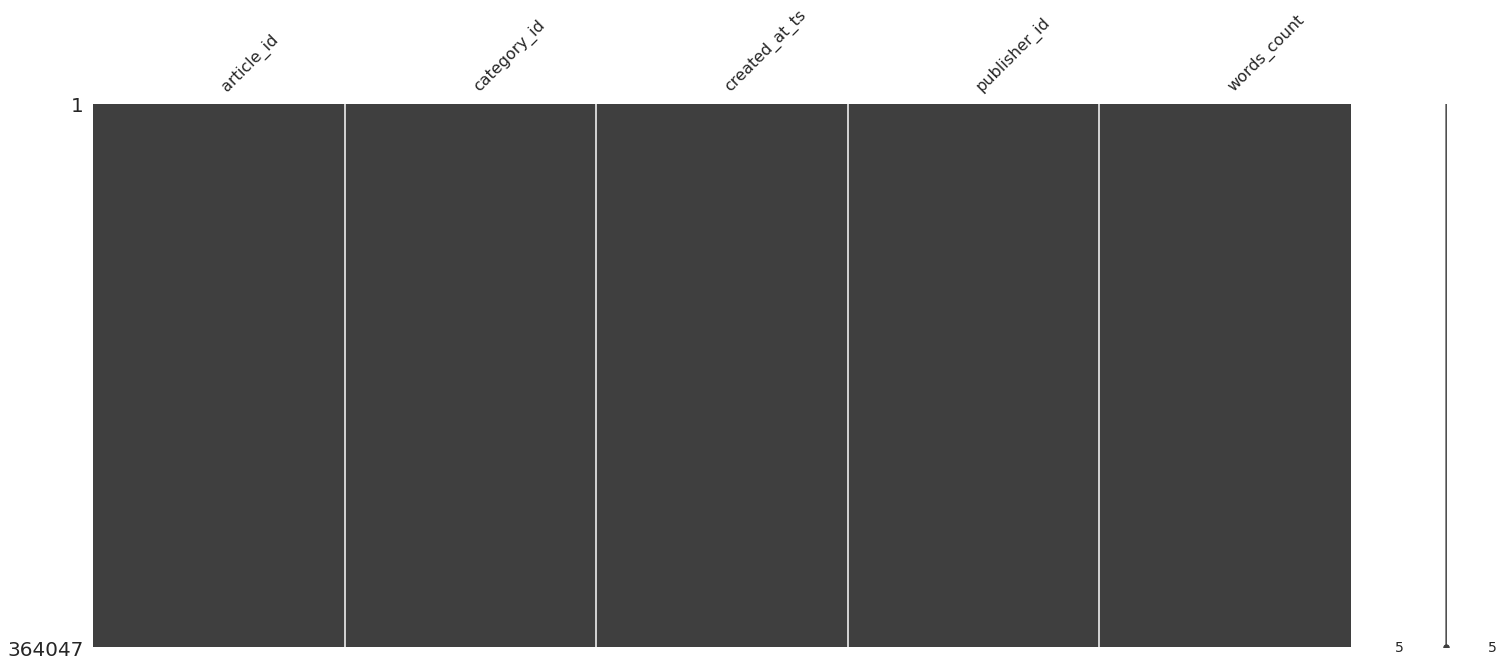

In [7]:
missingno.matrix(articles_df);

Aucune valeur n’est manquante.

In [8]:
articles_df['words_count'].describe()

count    364047.000000
mean        190.897727
std          59.502766
min           0.000000
25%         159.000000
50%         186.000000
75%         218.000000
max        6690.000000
Name: words_count, dtype: float64

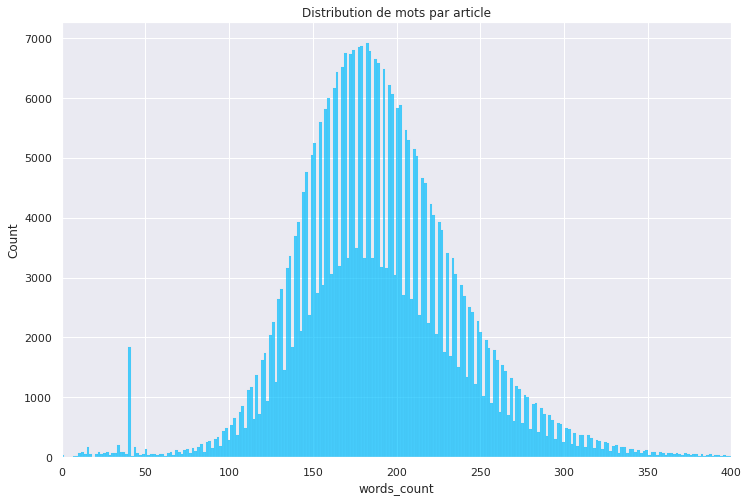

In [9]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.histplot(articles_df['words_count'],
            color="deepskyblue",
            edgecolor="black",
            alpha=0.7,
            ax=ax)

plt.xlim([0,400])
plt.title('Distribution de mots par article');
plt.show()

In [10]:
print(f'Article vide(s) : {articles_df[articles_df["words_count"] == 0].count()[0]}')

Article vide(s) : 35


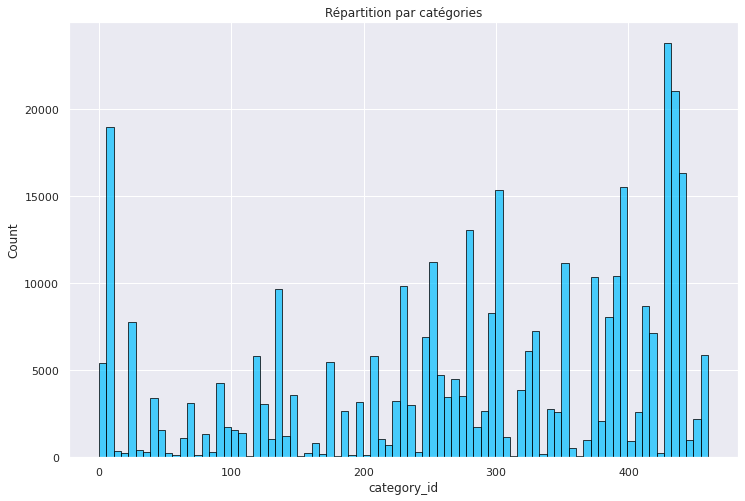

In [11]:
fig, ax = plt.subplots(figsize=(12, 8))

sns.histplot(articles_df['category_id'],
            color="deepskyblue",
            edgecolor="black",
            alpha=0.7,
            ax=ax)

plt.title('Répartition par catégories');
plt.show()

## clicks_{}.csv

### Contenu

In [12]:
PATH_CLICK_SAMPLE_DATA = "./input/clicks_sample.csv"
clicks_samp_df = pd.read_csv(PATH_CLICK_SAMPLE_DATA)

In [13]:
clicks_samp_df.head(5)

,user_id,session_id,session_start,session_size,click_article_id,click_timestamp,click_environment,click_deviceGroup,click_os,click_country,click_region,click_referrer_type
0,0,1506825423271737,1506825423000,2,157541,1506826828020,4,3,20,1,20,2
1,0,1506825423271737,1506825423000,2,68866,1506826858020,4,3,20,1,20,2
2,1,1506825426267738,1506825426000,2,235840,1506827017951,4,1,17,1,16,2
3,1,1506825426267738,1506825426000,2,96663,1506827047951,4,1,17,1,16,2
4,2,1506825435299739,1506825435000,2,119592,1506827090575,4,1,17,1,24,2


In [14]:
[print(x) for x in clicks_samp_df.columns];

user_id
session_id
session_start
session_size
click_article_id
click_timestamp
click_environment
click_deviceGroup
click_os
click_country
click_region
click_referrer_type


clicks_{}. csv contient 12 colonnes :

>- **user_id** : ID utilisateur

>- **session_id** : Session ID

>- **session_start** : Début de la session (horodatage)

>- **session_size** : nombre de clics/session

>- **words_count** : Total word contain in the article

>- **click_article_id** : l’utilisateur de l’ID de l’article a cliqué

>- **click_timestamp** : Lorsque l’utilisateur clique (timestamp)

>- **click_environment** : Environnement utilisateur lorsque vous cliquez

>- **click_deviceGroup** : périphérique utilisateur

>- **click_os** : système d’exploitation utilisateur

>- **click_country** : localisation (pays) lorsque l’utilisateur clique

>- **click_region** : localisation (région) lorsque l’utilisateur clique

>- **click_referrer_type** : ?



## Répartition

Concassons tous les fichiers de clics et observons nos données

In [15]:
# Concatenation des differents fichiers que constitue le jeu de données
all_files = glob.glob("input/clicks/*.csv")
data = []
for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0)
    data.append(df)

clicks = pd.concat(data, axis=0, ignore_index=True)

In [16]:
# Supprimer les colonnes inutilisées
all_clicks_df = clicks.drop(['session_id','session_start','session_size','click_timestamp','click_environment','click_deviceGroup',
'click_os','click_country','click_region','click_referrer_type'], axis = 1)

print(f"DataFrame shape : {all_clicks_df.shape}")

DataFrame shape : (2988181, 2)


## Élaborer nos modèles de recommandation

[Lien utile : créer un filtre collaboratif pour le moteur de recommandation](https://realpython.com/build-recommendation-engine-collaborative-filtering/)

### Préparation des données

Pour notre modèle de recommandation, nous devons trouver un système de notation pour aider le modèle à comprendre les préférences de chaque utilisateur.

J’ai décidé de procéder comme ça :

Rating = total-clic-par-catégorie-par-utilisateur / total-clic-fait-par-utilisateur

In [17]:
# Créer une carte pour convertir article_id en catégorie
dict_article_categories = articles_df.set_index('article_id')['category_id'].to_dict()

# Obtenir un associé Categorie pour chaque article 
all_clicks_df['category_id'] = all_clicks_df['click_article_id'].map(dict_article_categories).astype(int)
all_clicks_df['total_click'] = all_clicks_df.groupby(['user_id'])['click_article_id'].transform('count')
all_clicks_df['total_click_by_category_id'] = all_clicks_df.groupby(['user_id','category_id'])['click_article_id'].transform('count')
all_clicks_df['rating'] = all_clicks_df['total_click_by_category_id'] / all_clicks_df['total_click']

print(f'Forme avant de déposer un duplicata  : {all_clicks_df.shape}')
all_clicks_df = all_clicks_df.drop(['click_article_id'], axis=1)
all_clicks_df = all_clicks_df.drop_duplicates()
print(f'Forme après le dépôt du duplicata  : {all_clicks_df.shape}')

Forme avant de déposer un duplicata  : (2988181, 6)
Forme après le dépôt du duplicata  : (1882302, 5)


In [18]:
# Supprimer les colonnes non utilisées
all_clicks_df = all_clicks_df.drop(['total_click', 'total_click_by_category_id'], axis=1)

all_clicks_df[all_clicks_df['user_id'] == 0]

,user_id,category_id,rating
0,0,281,0.250
1,0,136,0.125
1287361,0,209,0.125
1287362,0,431,0.125
1352198,0,375,0.125
1535240,0,186,0.250


Nous n’avons plus besoin de Total_click et total_click_by_category_id.

In [19]:
# Garder ~42 000 utilisateurs pour construire notre modèle.
df = all_clicks_df[all_clicks_df['user_id'] < 42000]
print(f'Taille de notre échantillon  : {df.shape}')

Taille de notre échantillon  : (420672, 3)


In [20]:
# Un lecteur est toujours nécessaire mais seul le paramètre rating_scale est requis.
reader = Reader(rating_scale=(0, 1))

# Diviser notre dataframe 75% train / 25% test
data = Dataset.load_from_df(df[['user_id', 'category_id', 'rating']], reader)
train_set, test_set = train_test_split(data, test_size=.25)
print(f'Taille de l’ensemble d’essai : {len(test_set)}')

Taille de l’ensemble d’essai : 105168


## SVD (référence)

### Train Model

In [21]:
%%time
model = SVD().fit(train_set)

CPU times: user 16.6 s, sys: 0 ns, total: 16.6 s
Wall time: 16.6 s


### Résultats

In [22]:
predict = model.test(test_set)

# Imprimer nos résultats 
accuracy.rmse(predict)
accuracy.mse(predict)
accuracy.mae(predict);

print(f'Indice de prédiction pour l’utilisateur 0 avec catégorie 281 : {model.predict(0, 281).est}')
print(f'Current rating : {df[(df["user_id"] == 0) & (df["category_id"] == 281)]["rating"].values}')

RMSE: 0.1974
MSE: 0.0389
MAE:  0.1579
Indice de prédiction pour l’utilisateur 0 avec catégorie 281 : 0.6049138567940071
Current rating : [0.25]


### Prédictions avec jeu d’essai

In [23]:
# Fonction de https://github.com/NicolasHug/Surprise/blob/master/examples/top_n_recommendations.py
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.
    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.
    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # Commencer par mapper les prédictions à chaque utilisateur.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Puis trier les prédictions pour chaque utilisateur et récupérer les clés les plus élevées.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [24]:
top_n = get_top_n(predict, n=10)

In [25]:
# Faire une recommandation simple pour l’utilisateur.
def make_recommendation(user_ID, top_n, df_rating, articles_df):
    """Return a list of recommanded articles based on the taste of the user and all recommended categories
    Args:
        user_id -> user id used for recommendation
        top_n -> top-N recommendation for each user from a set of predictions
        df_rating -> df used to train our algo
        articles_df -> df with metadata of all articles.
    Returns:
        list(recommanded articles), list(recommanded categories)
    """
    # Obtenir le top 5 cat et l’ajouter à notre liste
    recommanded_cat = [iid for iid, _ in top_n[user_ID]]
    
    # Si nous n’avons pas de recommandation, utilisez nos données.
    if not recommanded_cat:
        recommanded_cat = df[df['user_id'] == user_ID].nlargest(1, ['rating'])['category_id'].values
    
    # Sélectionner 5 articles aléatoires pour chaque catégorie recommandé.
    random_articles_by_cat = [articles_df[articles_df['category_id'] == x]['article_id'].sample(5).values for x in recommanded_cat]
    
    # Sélectionner l’une des catégories recommandées et retourner 5 articles.
    rand_category = random.sample(random_articles_by_cat, 1)
    
    return rand_category[0], recommanded_cat

In [26]:
recommendation, categories = make_recommendation(1, top_n, df, articles_df)
print(f'catégories recommandées pour user_id[1] : {categories}')
print(f'articles recommandés pour user_id[1] : {recommendation}')

catégories recommandées pour user_id[1] : [123]
articles recommandés pour user_id[1] : [59851 59850 59856 59834 59838]


## KNNWithMeans (modèle collaboratif)

### Train Model

In [27]:
%%time 
# Pour utiliser la similarité de cosinus basée sur l’article
sim_options = {
    "name": "cosine",
    "user_based": False,  # Calculer les similitudes entre les éléments
}
model = KNNWithMeans(sim_options=sim_options).fit(train_set)

Computing the cosine similarity matrix...
Done computing similarity matrix.
CPU times: user 240 ms, sys: 0 ns, total: 240 ms
Wall time: 238 ms


### Résultats

In [28]:
predict = model.test(test_set)
#Print our Results
accuracy.rmse(predict)
accuracy.mse(predict)
accuracy.mae(predict);

RMSE: 0.0977
MSE: 0.0095
MAE:  0.0503


assez bon ! maintenant voyons si nos prédictions de modèle seront différentes de SVD 

In [29]:
print(f'Indice de prédiction pour l’utilisateur 0 avec catégorie 281 : {model.predict(0, 281).est}')
print(f'Current rating : {df[(df["user_id"] == 0) & (df["category_id"] == 281)]["rating"].values}')

Indice de prédiction pour l’utilisateur 0 avec catégorie 281 : 0.2711427932390439
Current rating : [0.25]


### Prédiction avec jeu d’essai 

In [30]:
top_n = get_top_n(predict, n=10)

In [31]:
recommendation, categories = make_recommendation(3, top_n, df, articles_df)

print(f'catégories recommandées pour user_id[0] : {categories}')
print(f'articles recommandés pour user_id[0] : {recommendation}')

catégories recommandées pour user_id[0] : [375]
articles recommandés pour user_id[0] : [233828 237388 235495 236250 235260]


## Prédiction fondée sur le contenu

Simple prédiction basée sur le contenu

[vers un article sur les données qui m’a aidé](https://towardsdatascience.com/recommender-system-in-python-part-1-preparation-and-analysis-d6bb7939091e)

### basée sur le contenu

In [32]:
df_cb = df.copy()

# Ajouter le nombre total de notation pour chaque 
num_ratings = pd.DataFrame(df_cb.groupby('category_id').count()['rating']).reset_index()
df_cb = pd.merge(left=df_cb, right=num_ratings, on='category_id')
df_cb.rename(columns={'rating_x': 'rating', 'rating_y': 'numRatings'}, inplace=True)

In [33]:
# Category_id
def get_similar_category(category_id, df, n_ratings_filter=50, n_recommendations=5):
    matrix = df.pivot_table(
        index='user_id',
        columns='category_id',
        values='rating'
    )
    
    similar = matrix.corrwith(matrix[category_id])
    corr_similar = pd.DataFrame(similar, columns=['correlation'])
    corr_similar.dropna(inplace=True)
    
    orig = df.copy()
    
    corr_with_category = pd.merge(
        left=corr_similar, 
        right=orig,
        on='category_id')[['category_id', 'correlation', 'numRatings']].drop_duplicates().reset_index(drop=True)
    
    result = corr_with_category[corr_with_category['numRatings'] > n_ratings_filter].sort_values(by='correlation', ascending=False)
    
    result = result[result['category_id'] != category_id]
    return result.head(n_recommendations)

In [34]:
result = get_similar_category(412, df_cb)

# Top 5 des catégories de corrélation avec category_id
result.head(5)

,category_id,correlation,numRatings
38,123,0.854137,5382
107,285,0.820774,1010
159,396,0.794898,1217
131,339,0.782811,824
138,353,0.716940,3297


### Evaluation

In [35]:
train, test = sklearn.model_selection.train_test_split(df_cb, test_size=0.3, random_state=42, shuffle=True)

In [36]:
%%time
all_categories = train['category_id'].unique()
predictions = {}

for val in all_categories:
    predictions[val] = get_similar_category(val, train)

CPU times: user 1min 58s, sys: 13.4 s, total: 2min 11s
Wall time: 2min 11s


In [37]:
train[train['user_id'] == 2]

,user_id,category_id,rating,numRatings
418918,2,332,0.25,2769


In [38]:
predictions[332]

,category_id,correlation,numRatings
125,402,1.000000,62
81,295,0.998921,74
54,211,0.996745,54
74,271,0.994981,53
46,184,0.992412,79


In [39]:
test[test['user_id'] == 2]

,user_id,category_id,rating,numRatings
71148,2,247,0.25,10563
81711,2,26,0.50,7542


Après quelques essais avec différents utilisateurs je réalise que le manque d’information ne me permet pas d’utiliser cette méthode de manière efficace

## Choisir le meilleur modèle et le meilleur déploiement

In [40]:
%%time

# Récupérer le train
train_set = data.build_full_trainset()

# Pour utiliser la similarité de cosinus basée sur l’article
sim_options = {
    "name": "cosine",
    "user_based": False, # Calculer les similitudes entre les éléments 
}

model = KNNWithMeans(sim_options=sim_options).fit(train_set)

Computing the cosine similarity matrix...
Done computing similarity matrix.
CPU times: user 1.02 s, sys: 15.7 ms, total: 1.04 s
Wall time: 1.03 s


In [41]:
def predict_best_category_for_user(user_id, model, article_df):
    predictions = {}
    
    # Catégories 1 à 460
    for i in range(1, 460):
        _, cat_id, _, est, err = model.predict(user_id, i)
        
        # Gardez la prédiction seulement si nous pouvons la garder.
        if (err != True):
            predictions[cat_id] = est
    
    best_cats_to_recommend = dict(sorted(predictions.items(), key=lambda x: x[1], reverse=True)[:5])
    
    recommended_articles = []
    for key, _ in best_cats_to_recommend.items():
        recommended_articles.append(int(articles_df[articles_df['category_id'] == key]['article_id'].sample(1).values))
    
    # Retourner articles-aléatoires-pour-la-meilleure-catégorie, la-meilleure-catégorie-de-recommander
    return recommended_articles, best_cats_to_recommend

In [42]:
results, recommended_cats = predict_best_category_for_user(1, model, articles_df)

print(f'Catégorie recommandé : {recommended_cats}')
print(f'5 articles aléatoires de catégorie {results}')

Catégorie recommandé : {22: 0.5, 70: 0.5, 159: 0.5, 370: 0.5, 62: 0.311823069331905}
5 articles aléatoires de catégorie [24993, 43057, 78546, 227595, 38866]


In [43]:
# Enregistrer dans le fichier dans le répertoire de travail actuel
pkl_filename = "pickle_surprise_model_KNNWithMeans.pkl"

with open(pkl_filename, 'wb') as file:
    pickle.dump(model, file)

# Charger à partir du fichier
with open(pkl_filename, 'rb') as file:
    pickle_model = pickle.load(file)

In [44]:
results, recommended_cats = predict_best_category_for_user(1, pickle_model, articles_df)

print(f'Catégorie recommandé : {recommended_cats}')
print(f'5 articles aléatoires de catégorie {results}')

Catégorie recommandé : {22: 0.5, 70: 0.5, 159: 0.5, 370: 0.5, 62: 0.311823069331905}
5 articles aléatoires de catégorie [24996, 43063, 78546, 227593, 38889]
